In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from src import generate, train, eval
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
import tyxe.util as util

import pickle

In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-tiny ======
Train: (-10, 10)
Y-space: -0.9768437254048131 - 0.9895705665423001
In Domain: (-10, 10)
Y-space: -1.0385097100233713 - 1.0644559293327118
Out Domain: (-20, 20)
Y-space: -1.098163400210471 - 1.0865503395764935


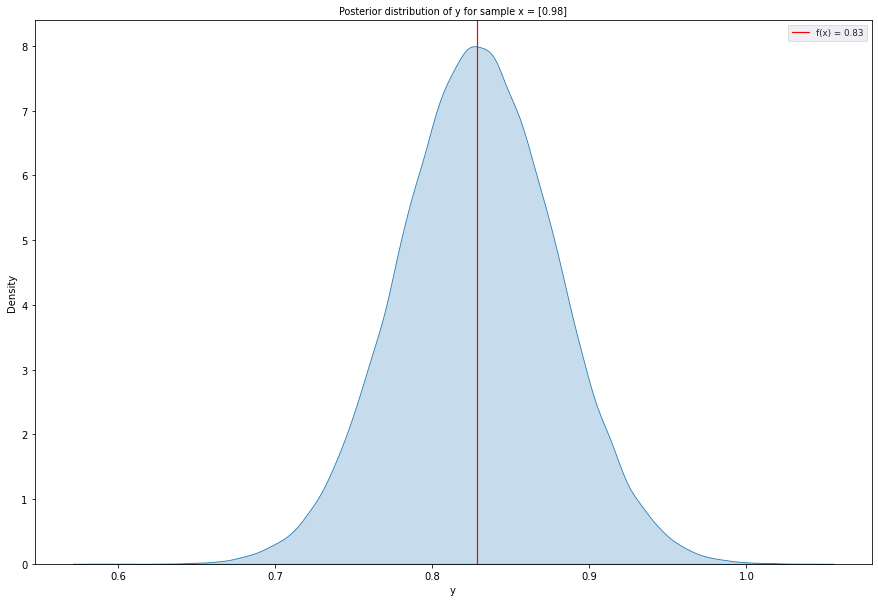

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test, y_test = torch.vstack((x_test_in_domain, x_test_out_domain)), torch.vstack((y_test_in_domain, y_test_out_domain))

In [7]:
x_train.shape, y_train.shape

(torch.Size([10, 1]), torch.Size([10, 1]))

In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128)

In [9]:
x, y = next(iter(train_dataloader))

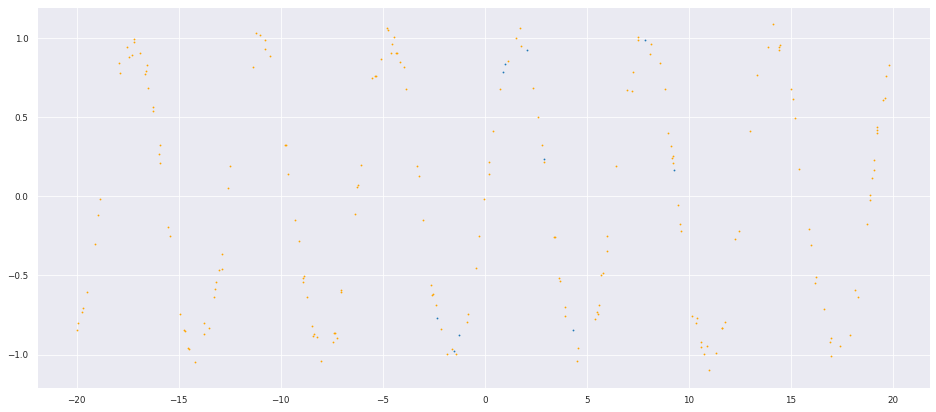

In [10]:

test_sort = torch.argsort(x_test.squeeze())
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1)

In [11]:
net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1))
#net = nn.Linear(1, 1)

In [12]:
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

In [13]:
print(len(x_train))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=0.001)

#obs_model = tyxe.likelihoods.LearnableGaussian(len(x_train), scale=5.0)
#obs_model = tyxe.likelihoods.HeteroskedasticGaussian(len(x_train))   #Må ha output 2d

#likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
likelihood_guide_builder = None


10


In [14]:
obs_model._scale

0.001

In [15]:
#guide_builder = poutine.block(partial(tyxe.guides.AutoNormal, init_scale=0.01), hide=["likelihood._scale"])
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)

In [16]:
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [17]:
if likelihood_guide_builder != None:
    with pyro.poutine.trace() as tr:
        bnn.guide(x)
        print(tr.trace.nodes.keys())
        print(tr.trace.nodes["likelihood._scale"]["value"])
        print(tr.trace.nodes["likelihood_guide.likelihood._scale.loc"]["value"])
        print(tr.trace.nodes["likelihood_guide.likelihood._scale.scale"]["value"])

In [18]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-4, "betas": (0.90, 0.999)})
elbos = []
def callback(bnn, i, e):
    if i % 100 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dataloader, optim, 20000, callback, num_particles=5)

epoch: 0 | elbo: 6281055.2
epoch: 100 | elbo: 3021357.3000000003
epoch: 200 | elbo: 2466980.4
epoch: 300 | elbo: 2260112.575
epoch: 400 | elbo: 1884315.4249999998
epoch: 500 | elbo: 1574574.775
epoch: 600 | elbo: 1534699.95
epoch: 700 | elbo: 1310670.1
epoch: 800 | elbo: 1417741.45
epoch: 900 | elbo: 1283223.55
epoch: 1000 | elbo: 1204906.5
epoch: 1100 | elbo: 1271924.05
epoch: 1200 | elbo: 1159211.3
epoch: 1300 | elbo: 1085895.6875
epoch: 1400 | elbo: 1058022.4625
epoch: 1500 | elbo: 1193501.125
epoch: 1600 | elbo: 1192151.5625
epoch: 1700 | elbo: 995077.6500000001
epoch: 1800 | elbo: 1093750.1875
epoch: 1900 | elbo: 1004052.6625000001
epoch: 2000 | elbo: 1074154.775
epoch: 2100 | elbo: 923881.8125
epoch: 2200 | elbo: 968940.8624999999
epoch: 2300 | elbo: 1073722.125
epoch: 2400 | elbo: 933251.1625000001
epoch: 2500 | elbo: 888418.4375
epoch: 2600 | elbo: 819232.1625000001
epoch: 2700 | elbo: 1051639.875
epoch: 2800 | elbo: 923054.625
epoch: 2900 | elbo: 866153.0625
epoch: 3000 | elbo

In [19]:
bnn.net.state_dict().keys()

odict_keys([])

In [20]:
#pickle.dump(bnn, open(f"{BASE_DIR}/models/{NAME}.pkl", "wb"))

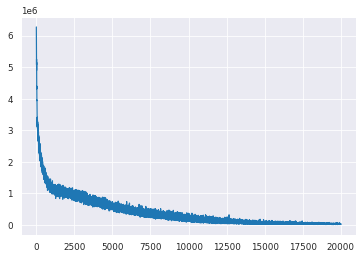

In [21]:
plt.plot(elbos)

In [22]:
trace = poutine.trace(bnn.guide).get_trace(x_test[0], y_test[0])

In [23]:
train_sort = torch.argsort(x_train.squeeze())
preds = bnn.predict(x_train[train_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

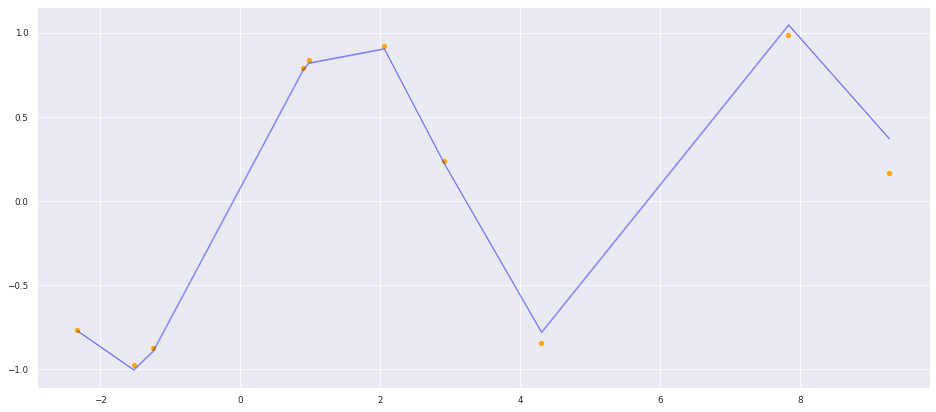

In [24]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="orange", s=20, alpha=1.0)
plt.plot(x_train[train_sort], means, color="blue", alpha=0.3)
for c in range(1, 4):
    plt.fill_between(x_train[train_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

In [25]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

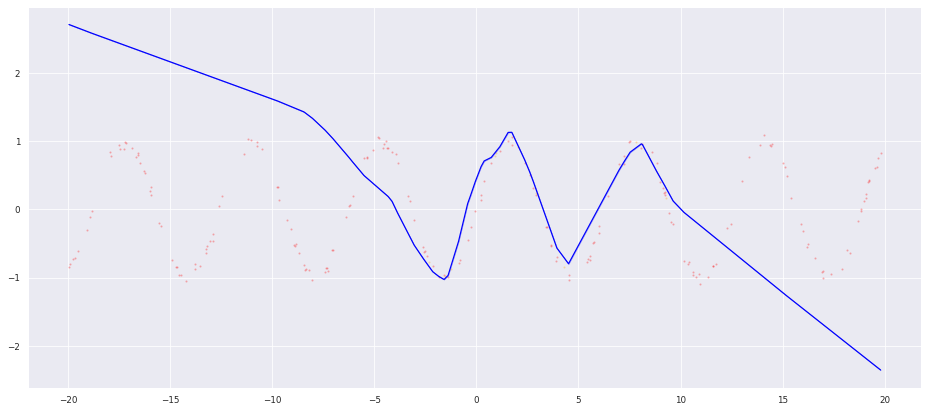

In [26]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

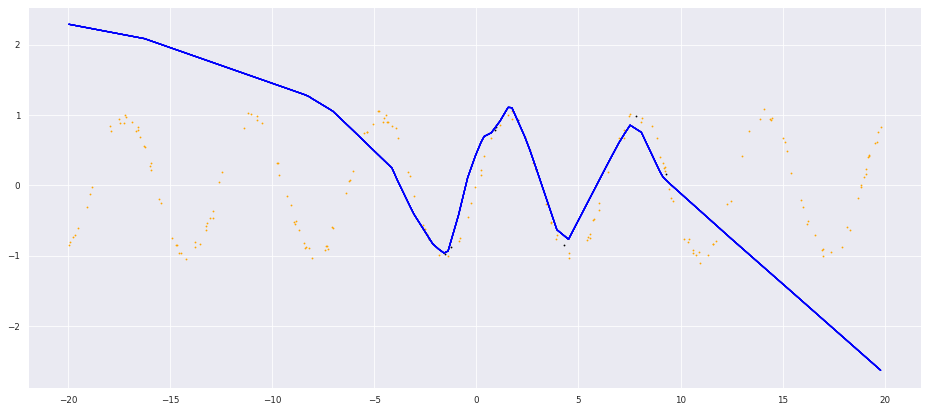

In [27]:


sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [28]:
bnn.get_error_metrics(x_train, y_train, num_predictions=100, reduction="mean")

(tensor(0.0034), tensor(-1678.1350), tensor(0.0461))